In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


In [2]:
transform = transforms.ToTensor() 

train_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False, 
    transform=transform,
    download=True
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False
)

print("Number of training batches:", len(train_loader))
print("Number of test batches:", len(test_loader))

for images, labels in train_loader:
    print("Batch image shape:", images.shape)
    print("Batch label shape:", labels.shape)
    break

Number of training batches: 938
Number of test batches: 157
Batch image shape: torch.Size([64, 1, 28, 28])
Batch label shape: torch.Size([64])


## Model: SimpleCNN
Architecture:
- `Conv2d(1→16, k3, p1) → ReLU → MaxPool2d(2)`
- `Conv2d(16→32, k3, p1) → ReLU → MaxPool2d(2)`
- `Flatten → Linear(32*7*7→128) → ReLU → Linear(128→10)`


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # (B,1,28,28) -> (B,16,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> (B,16,14,14)

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # -> (B,32,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2)                              # -> (B,32,7,7)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                # -> (B, 32*7*7)
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


### Forward test
모델을 완성했다면 아래 셀에서 **output shape = (4, 10)** 이 나와야 합니다.


In [4]:
model = SimpleCNN().to(device)

x = torch.randn(4, 1, 28, 28, device=device)
y = model(x)
print("output:", y.shape)


output: torch.Size([4, 10])


## Loss / Optimizer
- 분류(0~9) → `CrossEntropyLoss`
- 기본 optimizer → `Adam`


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## Train loop (2~3 epochs)


In [6]:
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f}")


Epoch 1/3 | Loss: 216.0460 | Train Acc: 0.9283
Epoch 2/3 | Loss: 58.3401 | Train Acc: 0.9807
Epoch 3/3 | Loss: 40.9252 | Train Acc: 0.9865


## Test evaluation


In [7]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print("Test Acc:", test_acc)


Test Acc: 0.9887


## 오답 1개 확인


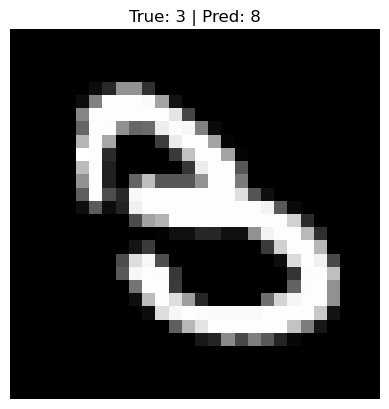

In [8]:
import matplotlib.pyplot as plt

model.eval()
mis = None

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        wrong = (preds != labels).nonzero(as_tuple=False)
        if len(wrong) > 0:
            idx = wrong[0].item()
            mis = (images[idx].detach().cpu(), int(labels[idx].cpu()), int(preds[idx].cpu()))
            break

if mis is None:
    print("No misclassified sample found (unlikely).")
else:
    img, y_true, y_pred = mis
    plt.figure()
    plt.imshow(img.squeeze(0), cmap="gray")
    plt.title(f"True: {y_true} | Pred: {y_pred}")
    plt.axis("off")
    plt.show()
